## Finetuning pre-trained in a self-supervised manner ViT transformer on LIDC dataset.

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
from torchvision import transforms
import pytorch_lightning as pl

In [2]:
%load_ext autoreload
%autoreload 2
    
from my_utils.plot_utils import plot_hists
from my_utils.norm_factors import compute_norm_factors
from End2End_Model import End2End_Model
from Biomarker_Model import Biomarker_Model
from LIDC_Dataset_E2E import LIDC_Dataset_E2E
from LIDC_Dataset_biom import LIDC_Dataset_biom

### Dividing dataset into three sets: training, validation and test sets.

In [3]:
# Paths
local = False
if local:
    data_path = "/home/jbinda/INFORM/LIDC/dataset"
    subsets_saving_path = "/home/jbinda/INFORM/LIDC/dataset/splitted_sets"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)
else:
    data_path = "/home/dzban112/LIDC/dataset"
    subsets_saving_path = "/home/dzban112/LIDC/dataset/splitted_sets"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)

In [4]:
#Reading all annotations and extracting paths, target: benign, malignant.
df = pd.read_pickle(f"{data_path}/ALL_annotations_df.pkl")
paths = df["path"]
targets_concepts = df[["target","subtlety", "calcification", "margin", "lobulation", 
                         "spiculation", "diameter", "texture", "sphericity"]].copy()

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(paths, targets_concepts, 
                                                            test_size=0.15, random_state=44, 
                                                            shuffle=True, stratify=targets_concepts["target"])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.15, random_state=44, 
                                                            shuffle=True, stratify=y_train_val["target"])

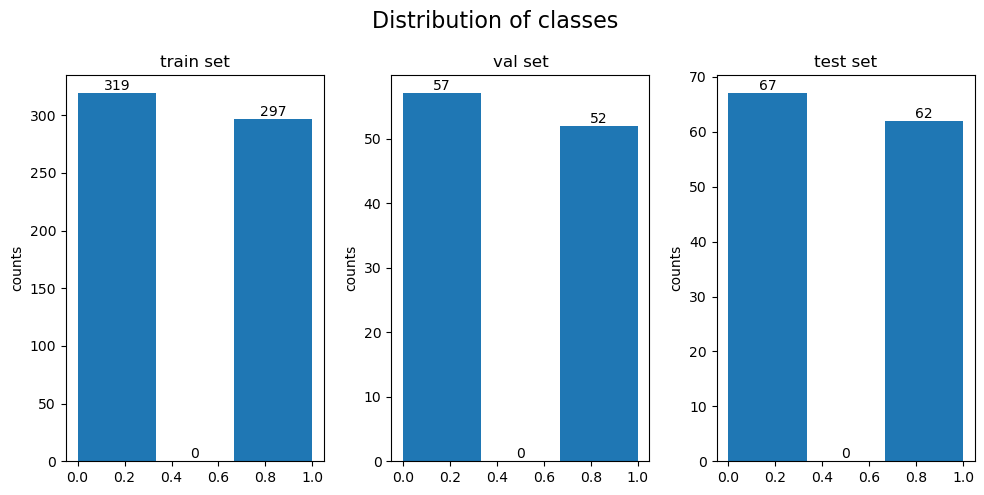

In [7]:
plot_hists(y_train, y_val,  y_test)

Data after splitting into test set and train/val set is well balanced. Splitted paths and targets/concepts are saved for downstream tasks.

In [8]:
with open(subsets_saving_path+"/"+"X_train.pkl", 'wb') as f:
    pickle.dump(X_train, f)

with open(subsets_saving_path+"/"+"X_test.pkl", 'wb') as f:
    pickle.dump(X_test, f)

with open(subsets_saving_path+"/"+"X_val.pkl", 'wb') as f:
    pickle.dump(X_val, f)

with open(subsets_saving_path+"/"+"y_train.pkl", 'wb') as f:
    pickle.dump(y_train, f)

with open(subsets_saving_path+"/"+"y_test.pkl", 'wb') as f:
    pickle.dump(y_test, f)

with open(subsets_saving_path+"/"+"y_val.pkl", 'wb') as f:
    pickle.dump(y_val, f)

### Computing Normalization Factors

In [8]:
with open(subsets_saving_path+"/"+"X_train.pkl", 'rb') as f:
    X_train = pickle.load(f)

mean, std = compute_norm_factors(X_train, data_path)

with open(subsets_saving_path+"/"+"fitted_mean_std.pkl", 'wb') as f:
    pickle.dump({"mean":mean, "std":std}, f)

print(f"Fitted mean: {mean:.3f}")
print(f"Fitted standard deviation: {std:.3f}")

Fitted mean: -628.999
Fitted standard deviation: 361.441


### Finetuning End2End Model

Finetuning was performed using slurm queuing system on the one GPU. To train model I have used python script `train_End2End.py`.

Training was performed with 50 epochs and I tried following sets of key hiperparameters: 
<br>
**1.** **ViT_E2E_1**, 10 trainable layers, dropout=0.00 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**2.** **ViT_E2E_2**, 20 trainable layers, dropout=0.05 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**3.** **ViT_E2E_3**, 30 trainable layers, dropout=0.07 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**4.** **ViT_E2E_4**, 40 trainable layers, dropout=0.08 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**5.** **ViT_E2E_5**, 50 trainable layers, dropout=0.09 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 

Models **ViT_E2E_3**, **ViT_E2E_4**, **ViT_E2E_5** achieved good results.

### Logs from Tensorboard:

#### Training Loss

<img src="training_plots/End2End/train1_loss.png">

#### Training Accuracy

<img src="training_plots/End2End/train1_ACC.png">

#### Validation loss

<img src="training_plots/End2End/val1_loss.png">

#### Validation Accuracy

<img src="training_plots/End2End/val1_ACC.png">

## End2End model evaluation on the test set

In [3]:
def model_evaluation(checkpoint_name):
    device="cuda"
    data_path="/home/dzban112/LIDC/dataset/"
    
    test_transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=-632.211, std=359.604),
    ])
    ds_test = LIDC_Dataset_E2E(
                    datadir=data_path,
                    transform=test_transform,
                    with_gen_imgs=False,
                    mode="test"
                )
    test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=16, num_workers=8)
    model = End2End_Model.load_from_checkpoint(f"checkpoints/End2End/{checkpoint_name}").to(device)
    
    torch.set_float32_matmul_precision('medium')
    trainer = pl.Trainer(accelerator="gpu", devices=1, precision="16-mixed")
    model.eval()
    res = trainer.test(model, dataloaders=test_loader)
    return res

In [9]:
# ViT_E2E_1
model_evaluation("best-checkpoint_1.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 17.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8217054009437561
        test_loss           0.35243603587150574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8217054009437561, 'test_loss': 0.35243603587150574}]

In [10]:
# ViT_E2E_2
model_evaluation("best-checkpoint_2.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 18.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8139534592628479
        test_loss           0.35828179121017456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8139534592628479, 'test_loss': 0.35828179121017456}]

In [11]:
# ViT_E2E_3
model_evaluation("best-checkpoint_3.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 18.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8372092843055725
        test_loss           0.3428272306919098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8372092843055725, 'test_loss': 0.3428272306919098}]

In [12]:
# ViT_E2E_4
model_evaluation("best-checkpoint_4.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 17.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8527131676673889
        test_loss           0.38885802030563354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8527131676673889, 'test_loss': 0.38885802030563354}]

In [13]:
# ViT_E2E_5
model_evaluation("best-checkpoint_5.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 17.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8449612259864807
        test_loss           0.3413655757904053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8449612259864807, 'test_loss': 0.3413655757904053}]

## Finetuning biomarker regression model

Fitting standard scaler for concepts z-score normalization:

In [9]:
from sklearn.preprocessing import StandardScaler

with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:].to_numpy() #without targets

SCALER = StandardScaler().fit(biomarkers)
with open(subsets_saving_path+"/"+"scaler.pkl", 'wb') as f:
    pickle.dump(SCALER, f)

In [12]:
with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:] #without targets

In [14]:
biomarkers.head()

,subtlety,calcification,margin,lobulation,spiculation,diameter,texture,sphericity
739,4.750000,3.750000,4.750000,1.250000,1.250000,9.563974,5.000000,4.500000
212,3.666667,5.333333,4.000000,1.666667,1.666667,6.950641,5.000000,4.000000
701,5.000000,6.000000,3.000000,2.750000,2.500000,38.389619,3.500000,3.000000
453,3.000000,6.000000,3.666667,1.000000,1.000000,7.505375,2.666667,3.333333
359,4.000000,4.500000,4.250000,3.000000,1.250000,10.479321,5.000000,2.500000


In [21]:
SCALER.mean_

array([ 4.17086039,  5.48092532,  4.08928571,  1.82467532,  1.70941558,
       13.31841242,  4.61268939,  3.8045184 ])

In [22]:
SCALER.var_

array([ 0.53394931,  0.97568008,  0.6879606 ,  0.67164221,  0.79473187,
       64.95064945,  0.57377973,  0.42182257])

Finetuning was performed using slurm queuing system on the one GPU. To train model I have used python script `train_biomarker.py`.

Training was performed with 50 epochs and I tried following sets of key hiperparameters: 
<br>
**1.** **ViT_biom_1**, 10 trainable layers, dropout=0.00 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**2.** **ViT_biom_2**, 20 trainable layers, dropout=0.05 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**3.** **ViT_biom_3**, 30 trainable layers, dropout=0.07 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**4.** **ViT_biom_4**, 40 trainable layers, dropout=0.08 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**5.** **ViT_biom_5**, 50 trainable layers, dropout=0.09 (only in the encoder), lr=3e-4 (exponential decay, $\beta=0.95$) 

### Train Loss

<img src="training_plots/Biomarkers/train_loss.png">

### Train MSE

<img src="training_plots/Biomarkers/train_mse.png">

### Validation MSE

<img src="training_plots/Biomarkers/val_mse.png">

### Validation RMSE

<img src="training_plots/Biomarkers/val_rmse.png">

## Biomarker Model evaluation on the test set

In [4]:
with open(data_path+"/splitted_sets"+"/"+"fitted_mean_std.pkl", 'rb') as f:
    dict_ = pickle.load(f)
with open(data_path+"/splitted_sets"+"/"+"scaler.pkl", 'rb') as f:
    SCALER = pickle.load(f)
    
MEAN = dict_["mean"]
STD = dict_["std"]

In [21]:
def biom_model_evaluation(checkpoint_name):
    device="cuda"
    data_path="/home/dzban112/LIDC/dataset/"
    
    test_transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    ds_test = LIDC_Dataset_biom(
                    datadir=data_path,
                    transform=test_transform,
                    label_transform=SCALER,
                    mode="test"
                )
    test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=16, num_workers=8)
    model = Biomarker_Model.load_from_checkpoint(f"checkpoints/Biomarkers/{checkpoint_name}").to(device)
    
    torch.set_float32_matmul_precision('medium')
    trainer = pl.Trainer(accelerator="gpu", devices=1, precision="16-mixed")
    model.eval()
    res = trainer.test(model, dataloaders=test_loader)
    return "Done"

In [44]:
# ViT_biom_1
biom_model_evaluation("best-checkpoint_1.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 20.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3346748948097229
        test_mse            0.8376173973083496
        test_rmse           0.9069604277610779
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Done'

In [45]:
# ViT_biom_2
biom_model_evaluation("best-checkpoint_2.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 20.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2487017959356308
        test_mse            0.5730066299438477
        test_rmse           0.7505964040756226
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Done'

In [46]:
# ViT_biom_3
biom_model_evaluation("best-checkpoint_3.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 20.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26281359791755676
        test_mse            0.6127091646194458
        test_rmse           0.7795337438583374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Done'

In [47]:
# ViT_biom_4
biom_model_evaluation("best-checkpoint_4.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 20.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.27023759484291077
        test_mse            0.6530024409294128
        test_rmse           0.8011810779571533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Done'

In [48]:
# ViT_biom_5
biom_model_evaluation("best-checkpoint_5.ckpt")

Using cache found in /home/dzban112/.cache/torch/hub/facebookresearch_dino_main
/apps/common/conda/2023.03/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /apps/common/conda/2023.03/lib/python3.10/site-packa ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 20.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.260785847902298
        test_mse            0.6139689683914185
        test_rmse           0.7805461287498474
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Done'